In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
%matplotlib inline

Sarimax

In [116]:
# Read csv da
df = pd.read_csv("data/coin_Bitcoin.csv", parse_dates=['Date'], index_col='Date')
df = df.asfreq('d')

In [117]:
# Split data into test and train
# Use September 2020 onwards due to volatility shift
_2020_onwards_slice = df[(df.index > '2020-11-01 23:59:59')]
training_set = _2020_onwards_slice.Close[:-30]
test_set = _2020_onwards_slice.Close[-30:]

In [118]:
training_set.isnull().any()

False

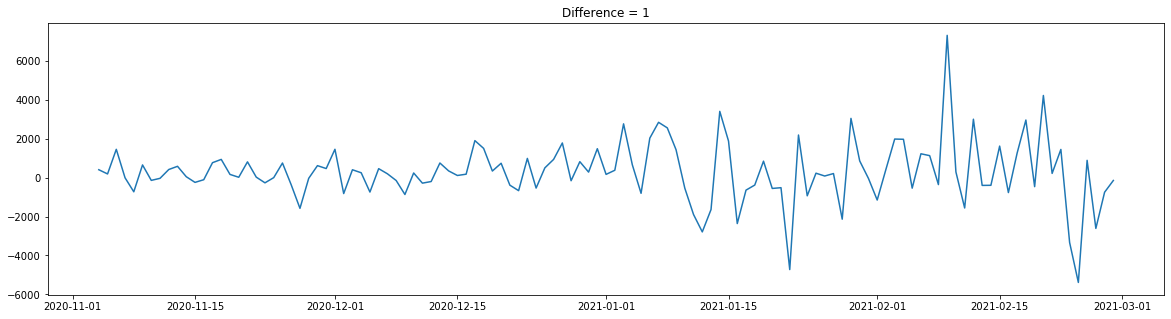

In [127]:
# Difference data once to remove trend. Plot to ensure stationarity after a single difference
diff = pd.DataFrame(_2020_onwards_slice.Close.diff().dropna())
plt.figure(figsize=(20,5))
plt.title('Difference = 1')
plt.plot(diff, label='Differenced')

In [120]:
# Create model using p, d, q parameters
model = SARIMAX(training_set, trend='c', order=(14,1,2), enforce_stationarity=False, enforce_invertibility=False)

In [121]:
# Train the model on the training set
results = model.fit(maxiter=200)

In [122]:
preds = results.predict(start=df.Close.index[-30], end=df.Close.index[-1])

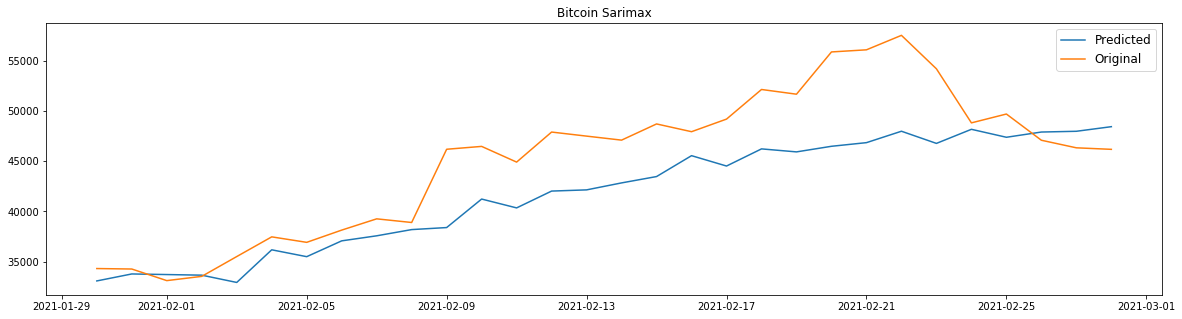

In [123]:
plt.figure(figsize=(20,5))
plt.plot(preds, label='Predicted')
plt.plot(df.Close[-30:], label='Original')
plt.legend(fontsize=12)
plt.title("Bitcoin Sarimax");

Varmax

In [124]:
# Get open and colse columns
df_open = pd.DataFrame(df.Open)
df_close = pd.DataFrame(df.Close)
# Create range data frame from open -> close range
df_range = pd.DataFrame(df_open.Open - df_close.Close, columns=["Range"])
# Create range data frame from Min and Max daily price
df_max_min_range = pd.DataFrame(df.High - df.Low, columns=["Max_Min_Range"])
# Create data frame for average daily between open and close
df_average = pd.DataFrame((df_open.Open + df_close.Close)/2, columns=["Average"])

df_close_range = df_close.rename(columns={"Close": "close"})
df_close_range["open_close_range"] = df_range.Range
df_close_range["max_min_range"] = df_max_min_range.Max_Min_Range

In [125]:
# Get ema stats for use with model parameters
_12_ema = df.Close.ewm(span=12, adjust=False).mean()
_24_ema = df.Close.ewm(span=24, adjust=False).mean()

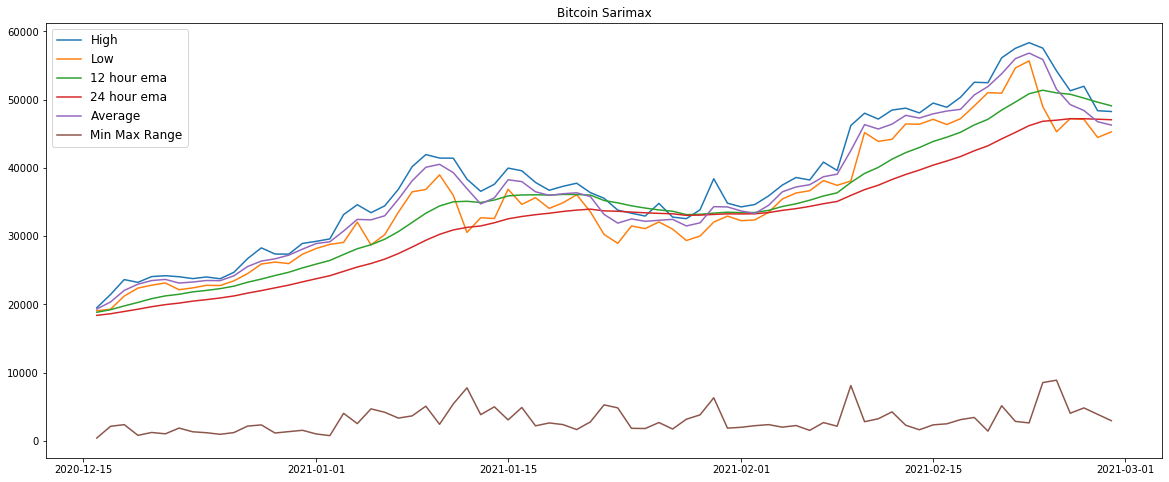

In [126]:
# As the min max range increases the volatility increases - volatlity score to increase the weight of errors
plt.figure(figsize=(20,8))
plt.plot(df.High[-75:], label="High")
plt.plot(df.Low[-75:], label='Low')
plt.plot(_12_ema[-75:], label='12 hour ema')
plt.plot(_24_ema[-75:], label='24 hour ema')
plt.plot(df_average.Average[-75:], label="Average")
plt.plot(df_max_min_range[-75:], label="Min Max Range")
plt.legend(fontsize=12)
plt.title("Bitcoin Sarimax");